In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import math
from tabulate import tabulate
from pathlib import Path
from collections import Counter
import re
import json

# Syscall By Arch

In [ ]:
num_x86_calls = 608 - 247 + 1

unique_calls = {
    "x86_64": 56,
    "aarch64": 0,
    "rv64": 2
}

common_calls = num_x86_calls - unique_calls["x86_64"]

archs = ["x86_64", "rv64", "aarch64"]

syscall_archs = {}

for arch in archs:
    syscall_archs[arch] = {
        "common": common_calls,
        "unique": unique_calls[arch]
    }
print(syscall_archs)

In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(1.5)

keys = list(syscall_archs.keys())
common_vals = [x["common"] for x in syscall_archs.values()]
unique_vals = [x["unique"] for x in syscall_archs.values()]

colors = ["green", "orange"]
labels = ["common", "arch-specific"]
lefts = [0, 0, 0]
b = []
for bars, col, label in zip([common_vals, unique_vals], colors, labels):
    print(keys, bars, col, lefts, label)
    b = ax.barh(keys, bars, left=lefts, color=col, height=0.6, label=label)
    lefts = [lefts[i] + bars[i] for i in range(len(common_vals))]

ax.set_xlim(right=550)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.grid(linestyle='dashed')
ax.legend(title="Syscall Implementation", loc="upper right")

In [ ]:
fig.savefig("figures/syscall_archs", dpi=600, bbox_inches='tight')

# Syscall Diagnostics

In [ ]:
def parse_strace_summary(filename):
    syscalls = {}

    with open(filename, 'r') as file:
        lines = file.readlines()

        for line in lines[2:-2]:  # Skipping the headers
            parts = line.split()
            if len(parts) < 5:
                continue
            
            # Check if the 'errors' column is populated
            if parts[4].isdigit():
                syscall = parts[5]
            else:
                syscall = parts[4]
                
            calls = math.log(int(parts[3]))
            syscalls[syscall] = calls

    return syscalls

# Testing the function
sp_path = Path("syscall_profiles/")

sp_dict = {file.name.split('.')[0]: parse_strace_summary(file) for file in sp_path.iterdir()}

total_sp = {}
print(f"Num bins: {len(sp_dict)}")
for k, v in sp_dict.items():
    for sc, ct in v.items():
        if sc not in total_sp:
            total_sp[sc] = ct
        else:
            total_sp[sc] += ct
        if sc == "prlimit64":
            print(k)
print(f"Num syscalls: {len(total_sp)}")
# Total sp: syscall_freq


In [ ]:
#print(total_sp)
sorted_total_sp = {k: v for k, v in sorted(total_sp.items(), key=lambda item: item[1])[::-1]}
print(sorted_total_sp)

In [ ]:
N = None

def top_n(d):
    return list(d)[:N]

xscale = top_n(sorted_total_sp.keys())
print(xscale)

def plot_profile(lst, i, app_name):
    vals = np.array(top_n(lst), dtype=float)
    vals /= np.sum(vals)
    p1 = ax[i].bar(xscale, vals, color='purple')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_ylabel(app_name.split('-')[0], fontsize='10')
    

apps = ["bash", "memcached-testapp", "sqlite3"] #"paho-bench"

fig, ax = plt.subplots(1+len(apps), 1, figsize=(8, 5))

# Total
vals = np.array(top_n(sorted_total_sp.values()), dtype=float)
vals /= np.sum(vals)
p1 = ax[0].bar(xscale, vals)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_ylabel("Aggregate", fontsize='12')


i = 1
for app in apps:
    sp_app = sp_dict[app]
    sorted_sp = [sp_app[x] if x in sp_app else 0 for x in xscale]
    plot_profile(sorted_sp, i, app)
    i += 1


In [ ]:
fig.savefig("figures/syscall_profile", dpi=600, bbox_inches='tight')

# WALI Microbenchmarks

In [ ]:
# Parse file to get syscall NRs index dict\n",
#  sysidx_dict: Map SC to number\n",
#  syscall_names: Map number to SC\n",
#  call_freq_scale: Sorted by aggregate\n",
syscall_names = [None] * 500
with open("meta/syscall_list.nr", "r") as f:
    pattern = re.compile(r"__NR_(\S*)\s+(\d+)")
    matches = [pattern.search(line) for line in f.readlines()]
    sysidx_dict = {match.group(1): int(match.group(2)) for match in matches}
    for k, v in sysidx_dict.items():
        print(v)
        syscall_names[v] = k

call_freq_scale = sorted(sysidx_dict, key=sysidx_dict.get)
print(sysidx_dict)


In [ ]:
micro_path = Path("microbenchmarks")
nprof_path = micro_path / "native_profiles"

def profile_dict(profile_file):
    with open(profile_file) as f:
        list_stats = f.read().split(',')
        fields = ["count", "native", "virtual"]
        feats = [dict(zip(fields, [int(x) for x in re.search("(\d*):(\d*)/(\d*)", elem).groups()])) for elem in list_stats]
        for i, ft in enumerate(feats):
            final_dict = {syscall_names[i]: ft for i, ft in enumerate(feats)}
            for k, v in final_dict.items():
                final_dict[k]["overhead"] = final_dict[k]["virtual"] - final_dict[k]["native"]
            return final_dict

ndict_all = {pt.name.split('.')[0]: profile_dict(pt) for pt in nprof_path.iterdir()}

ndict_comp = {}

for sc in syscall_names:
    sc_fts = [v[sc] for v in ndict_all.values()]
    ov = 0
    ct = 0
    if sc == 'fork':
        print(sc_fts)
    for ft in sc_fts:
        ov += int(ft['overhead']) * int(ft['count'])
        ct += int(ft['count'])
    ndict_comp[sc] = int(ov / ct) if ct else 0

#for nd in ndict_all.values():
#    for k, v in nd.items():
#        if k in ndict_comp:
#            ndict_comp[k] += v["count"] * v["overhead"]
#        else:
#            ndict_comp[k] = v["count"] * v["overhead"]
#print(ndict_all)

In [ ]:
#for k, v in final_dict.items():
print ("{:<20} {:<10} {:<15} {:<15} {:<10}".format('Syscall', 'Count', 'Native (ns)', 'Virtual (ns)', 'Overhead (ns)'))
#for k, v in sorted(ndict.items(), key=lambda x: x[1]["overhead"], reverse=True):
x = 35
topx_dict = {k: ndict_all["memcached2"][k] for k in xscale[:x]}
for k, v in topx_dict.items():
    print ("{:<20} {:<10} {:<15} {:<15} {:<10}".format(k, v["count"], v["native"], v["virtual"], v["virtual"] - v["native"]))

In [ ]:
#for k, v in final_dict.items():
print ("{:<20} {:<10}".format('Syscall', 'Overhead (ns)'))
#for k, v in sorted(ndict.items(), key=lambda x: x[1]["overhead"], reverse=True):
x = 35
rm_list = ['clock_nanosleep', 'brk', 'arch_prctl', 'set_robust_list', 'dup2', 'openat', 'execve']
add_list = ['open', 'fork']

micro_xscale = [i for i in xscale[:x] if i not in rm_list]
micro_xscale.insert(3, 'open')
micro_xscale.append('fork')

topx_dict = {k: ndict_comp[k] for k in micro_xscale[:x]}
for k, v in topx_dict.items():
    print ("{:<20} {:<10}".format(k, v))

In [ ]:
for sc, ov in topx_dict.items():
    print(f"    {sc} & {ov} & ---\\\\")
    print("    \hline")

# Overhead

In [2]:
overheads = {
    "lua": {
        "exec": 1212590589,
        "native": 28864706,
        "wali":    1253915
    },
    
    "bash": {
        "exec":   567840904,
        "native": 134039941,
        "wali":   6096545
    },
    
    "sqlite3": {
        "exec":   295207080,
        "native": 163690152,
        "wali":     2339408
    },
    
    "paho-bench": {
        "exec":    1276177263,
        "native":    23496869,
        "wali":       6967199
    },
    
    
    "memcached": {
        "exec":    5036729742,
        "native":   567234459,
        "wali":     136861725
    },
}



['lua', 'bash', 'sqlite3', 'paho-bench', 'memcached'] [1.21259059 0.5678409  0.29520708 1.27617726 5.03672974] C0 [0, 0, 0, 0, 0] wasm-app
['lua', 'bash', 'sqlite3', 'paho-bench', 'memcached'] [0.02886471 0.13403994 0.16369015 0.02349687 0.56723446] orange [1.212590589, 0.567840904, 0.29520708, 1.276177263, 5.036729742] sys
['lua', 'bash', 'sqlite3', 'paho-bench', 'memcached'] [0.00125391 0.00609655 0.00233941 0.0069672  0.13686172] green [1.241455295, 0.701880845, 0.458897232, 1.2996741319999998, 5.603964201] wali


Text(0, 0.5, 'Exec Time (s)')

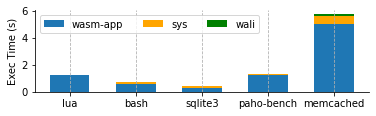

In [18]:
fig, ax = plt.subplots(1, figsize=(6, 1.5))

keys = list(overheads.keys())

exec_arr = []
native_arr = []
wali_arr = []

for k, v in overheads.items():
    exec_arr.append(v["exec"])
    native_arr.append(v["native"])
    wali_arr.append(v["wali"])

colors = ["C0", "orange", "green"]
labels = ["wasm-app", "sys", "wali"]
bottoms = [0, 0, 0, 0, 0]
b = []
for bars, col, label in zip([exec_arr, native_arr, wali_arr], colors, labels):
    barf = np.array(bars) / 1e9
    print(keys, barf, col, bottoms, label)
    b = ax.bar(keys, barf, bottom=bottoms, color=col, width=0.6, label=label)
    bottoms = [bottoms[i] + barf[i] for i in range(len(exec_arr))]

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.grid(linestyle='dashed')
ax.legend(loc="upper left", ncols=3, fontsize=10)
ax.set_ylabel("Exec Time (s)")

In [19]:
fig.savefig("figures/macrobench_time", dpi=600, bbox_inches='tight')